In [2]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {v:k+1 for k,v in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}
vocab_size = len(stoi)

In [4]:
def build_dataset(block_size, data):
    X, Y = [], []
    for word in data:
        context = [0] * block_size
        for char in word + '.':
            X.append(context)
            Y.append(stoi[char])
            context = context[1:] + [stoi[char]]
    return torch.tensor(X), torch.tensor(Y)

train_len = int(len(words) * 0.8)
val_len = int(len(words) * 0.9)
block_size = 8
random.seed(42)
random.shuffle(words)
X_tr, Y_tr = build_dataset(block_size, words[:train_len])
X_d, Y_d = build_dataset(block_size, words[train_len:val_len])
X_t, Y_t = build_dataset(block_size, words[val_len:])

In [5]:
# simplified by adding embedding, flatten and sequential classes
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):
        self.momentum = momentum
        self.eps = eps
        self.training = True
        self.beta = torch.zeros(dim)
        self.gamma = torch.ones(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if x.ndim==2:
            dim = 0
        elif x.ndim == 3:
            dim = (0,1)
        if self.training:
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out =  self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        # self.out = x.view(x.shape[0], -1)
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [6]:
torch.manual_seed(42)

In [ ]:
n_hidden = 200  # number of neurons in the hidden layer of MLP
n_embd = 10  # embedding dimension

# # C = torch.randn((vocab_size, n_embd))  # use the embedding and flatten class
# layers = [
#     Embedding(vocab_size, n_embd), Flatten(), Linear(block_size*n_embd, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

# instead of maintaining layers list
model = Sequential([Embedding(vocab_size, n_embd), FlattenConsecutive(block_size), Linear(block_size*n_embd, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# parameters = [p for layer in layers for p in layer.parameters()] # after embedding and flatten classes
parameters = model.parameters()  # after sequential class
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


22097


In [58]:
# optimization
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # emb = C[Xb]  # og
    # x = emb.view(emb.shape[0], -1)   # og

    # after adding embedding and flattening class
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    # loss = F.cross_entropy(x, Yb)  # loss function

    # after adding seqential class
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    #track stats
    lossi.append(loss.log10().item())
    if i%10000==0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')

    # break  # for debugging


0/200000 : 3.3065
10000/200000 : 2.0864
20000/200000 : 2.0428
30000/200000 : 2.5307
40000/200000 : 2.2639
50000/200000 : 2.0690
60000/200000 : 2.3772
70000/200000 : 1.8091
80000/200000 : 1.9148
90000/200000 : 2.3726
100000/200000 : 2.3695
110000/200000 : 2.0215
120000/200000 : 2.0369
130000/200000 : 2.3383
140000/200000 : 2.7433
150000/200000 : 2.0364
160000/200000 : 1.7532
170000/200000 : 1.8577
180000/200000 : 1.8637
190000/200000 : 2.0255


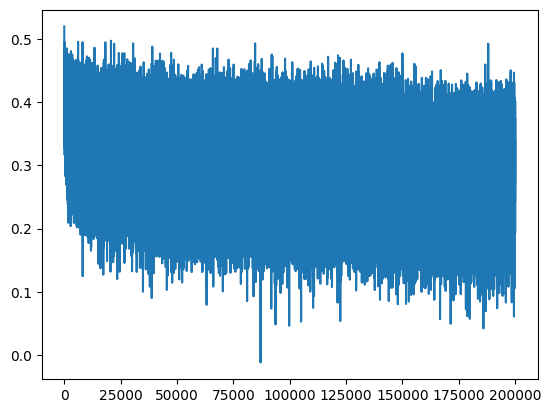

In [59]:
plt.plot(lossi)

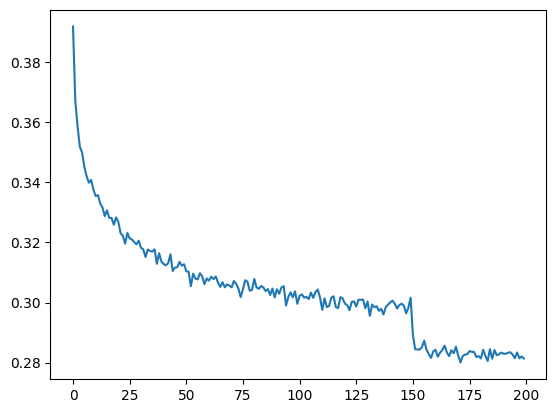

In [60]:
# better readability for the above plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [61]:
# put layers into eval mode (needed for batchnorm layers especially)
for layer in model.layers:
    layer.training = False

In [62]:
# evaluate loss
def split_loss(split):
    x,y = {'train':(X_tr, Y_tr),
     'val':(X_d, Y_d),
     'test':(X_t, Y_t)}[split]
    
    # emb = C[x]
    # x = emb.view(emb.shape[0],-1)

    # for layer in layers:
    #     x = layer(x)

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')
    

train 1.9261376857757568
val 2.0491700172424316


In [63]:
# sample from model

for i in range(20):
    out = ''
    context = [0] * block_size
    while True:
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0],-1)
        # for layer in layers:
        #     x = layer(x)
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out += itos[ix]
        if ix == 0:
            break
    print(out)

melae.
lyri.
gwosxnyn.
coylyn.
kaycene.
sharletti.
dayan.
ahroiah.
jhanisik.
daci.
graquatu.
egeb.
akavyn.
aleel.
hamby.
dwoodn.
uhahari.
malina.
arfeldo.
alia.


**performance log**
- original (8 char context + 200 hidden neurons + 22K params):
    - train: 1.9261376857757568
    - val: 2.0491700172424316

but this network doesn't makes much sense, we are crushing way too much info way too fast so let's implement the hierarchial scheme

wavenet: https://arxiv.org/pdf/1609.03499

In [ ]:
n_hidden = 68  # number of neurons in the hidden layer of MLP , 68 to get roughly 22k params as above
n_embd = 10  # embedding dimension

model = Sequential([Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident

parameters = model.parameters()  
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


22397


In [67]:
# let's look at a batch of 4 samples
ix  = torch.randint(0, X_tr.shape[0], (4,))
Xb, Yb = X_tr[ix], Y_tr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  2, 12,  1,  4,  5],
        [ 0,  0,  0,  0,  0,  3,  5,  9],
        [ 0,  0,  0,  0,  0,  4,  9, 25],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [68]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', layer.out.shape)

Embedding : torch.Size([4, 8, 10])
FlattenConsecutive : torch.Size([4, 4, 20])
Linear : torch.Size([4, 4, 200])
BatchNorm1d : torch.Size([4, 4, 200])
Tanh : torch.Size([4, 4, 200])
FlattenConsecutive : torch.Size([4, 2, 400])
Linear : torch.Size([4, 2, 200])
BatchNorm1d : torch.Size([4, 2, 200])
Tanh : torch.Size([4, 2, 200])
FlattenConsecutive : torch.Size([4, 400])
Linear : torch.Size([4, 200])
BatchNorm1d : torch.Size([4, 200])
Tanh : torch.Size([4, 200])
Linear : torch.Size([4, 27])


In [70]:
# optimization
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    Xb, Yb = X_tr[ix], Y_tr[ix]
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    #track stats
    lossi.append(loss.log10().item())
    if i%10000==0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')

    # break  # for debugging


0/200000 : 3.2794
10000/200000 : 2.0317
20000/200000 : 2.1378
30000/200000 : 2.1466
40000/200000 : 2.1773
50000/200000 : 2.3140
60000/200000 : 2.0984
70000/200000 : 2.0471
80000/200000 : 2.2591
90000/200000 : 1.8979
100000/200000 : 1.6197
110000/200000 : 1.8271
120000/200000 : 1.7700
130000/200000 : 1.6563
140000/200000 : 1.9808
150000/200000 : 1.8320
160000/200000 : 2.0594
170000/200000 : 1.6569
180000/200000 : 1.7071
190000/200000 : 1.7607


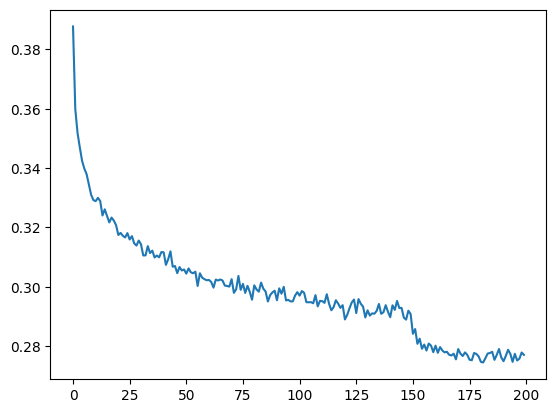

In [71]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [72]:
# put layers into eval mode (needed for batchnorm layers especially)
for layer in model.layers:
    layer.training = False

In [73]:
# evaluate loss
def split_loss(split):
    x,y = {'train':(X_tr, Y_tr),
     'val':(X_d, Y_d),
     'test':(X_t, Y_t)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')
    

train 1.9037941694259644
val 2.0432631969451904


In [74]:
# sample from model
for i in range(20):
    out = ''
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out += itos[ix]
        if ix == 0:
            break
    print(out)

onela.
taylo.
kenna.
erio.
jaliyah.
aroxap.
raymeigh.
khadhi.
rashia.
destyn.
myvandle.
aylim.
andrijah.
richaela.
wilfienni.
augugumon.
surita.
evelin.
ivyana.
phope.


**performance log**
- original (8 char context + 200 hidden neurons + 22K params):
    - train: 1.9261376857757568, val: 2.0491700172424316
- hierarchial - 8 char context + 68 hidden neurons + 22K params
    - train 1.9037941694259644,val 2.0432631969451904